In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

from notebooks.util.distribution_utils import *
from liquidity.features import compute_returns

from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

## Load limit orders raw sample data

In [4]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'limit_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['AAPL']

In [5]:
display(tsla_raw_df)

,Unnamed: 0,event_timestamp,side,lob_action,order_executed,execution_price,execution_size,ask,ask_volume,bid,...,sign,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,184298,2017-01-03 10:30:06.086276667,ASK,INSERT,False,NaN,0,219.39,600.0,219.24,...,1,0.000,0.000,0.15,2017-01-03,-0.008536,1046891,10525,0.008043,1
1,184301,2017-01-03 10:30:07.196391542,BID,INSERT,False,NaN,0,219.39,601.0,219.24,...,-1,0.005,-0.005,0.15,2017-01-03,-0.008536,1046891,10525,0.735490,-100
2,184306,2017-01-03 10:30:11.045448316,ASK,INSERT,False,NaN,0,219.39,601.0,219.25,...,1,-0.005,-0.005,0.14,2017-01-03,-0.008536,1046891,10525,0.804315,100
3,184310,2017-01-03 10:30:11.050966641,BID,INSERT,False,NaN,0,219.38,100.0,219.25,...,-1,0.010,-0.010,0.13,2017-01-03,-0.008536,1046891,10525,0.147098,-20
4,184315,2017-01-03 10:30:13.741020687,BID,INSERT,False,NaN,0,219.38,100.0,219.27,...,-1,0.005,-0.005,0.11,2017-01-03,-0.008536,1046891,10525,0.735490,-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916012,132494,2017-12-29 14:59:50.387381942,ASK,INSERT,False,NaN,0,311.07,60.0,311.02,...,1,0.000,0.000,0.05,2017-12-29,-0.009936,831774,10502,0.197427,30
3916013,132495,2017-12-29 14:59:50.387424556,ASK,INSERT,False,NaN,0,311.07,90.0,311.02,...,1,0.005,0.005,0.05,2017-12-29,-0.009936,831774,10502,0.065809,10
3916014,132524,2017-12-29 14:59:51.681088180,BID,INSERT,False,NaN,0,311.10,3400.0,311.00,...,-1,0.000,-0.000,0.10,2017-12-29,-0.009936,831774,10502,0.331081,-50
3916015,132535,2017-12-29 14:59:57.755582069,ASK,INSERT,False,NaN,0,311.10,3400.0,311.00,...,1,0.000,0.000,0.10,2017-12-29,-0.009936,831774,10502,0.658091,100


## 1. Returns

In [6]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'AAPL': appl_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# returns = {stock: data.head(1000000) for stock, data in returns.items()}

### 1.1. Stationarity Test
To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:
- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.
- **H1:** The time series is stationary.
- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [7]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -232.21
p-value: 0.00,
N: 499991, 
critical values: {'1%': -3.430363078902566, '5%': -2.8615457807209896, '10%': -2.5667730768666197}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -109.31
p-value: 0.00,
N: 499958, 
critical values: {'1%': -3.43036307976585, '5%': -2.8615457811025506, '10%': -2.5667730770697106}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -351.98
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -189.68
p-value: 0.00,
N: 499987, 
critical values: {'1%': -3.4303630790072, '5%': -2.861545780767237, '10%': -2.5667730768912356}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EB

### 1.2. Plot returns density functions

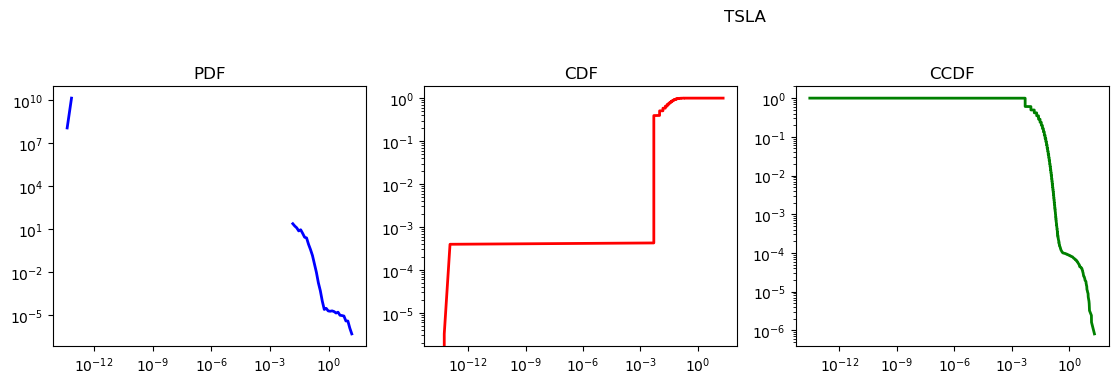

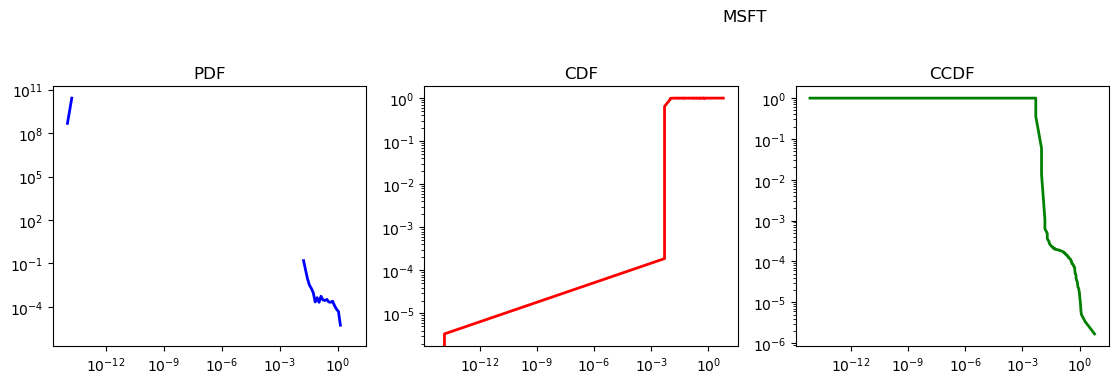

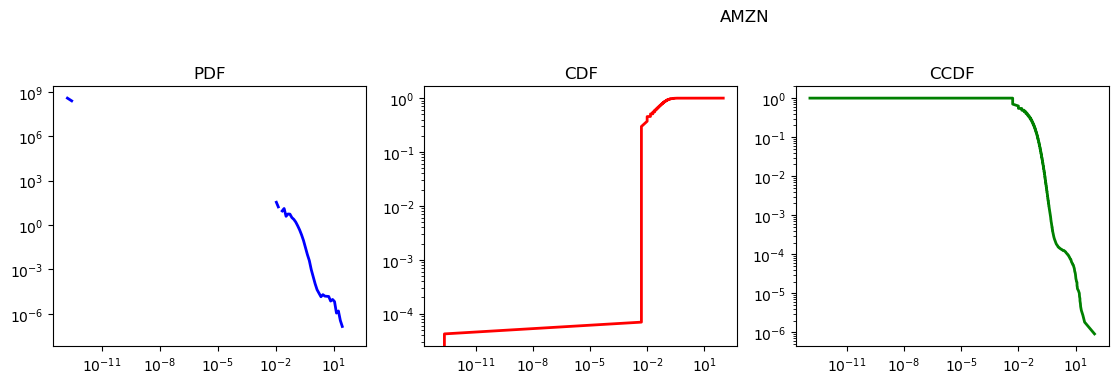

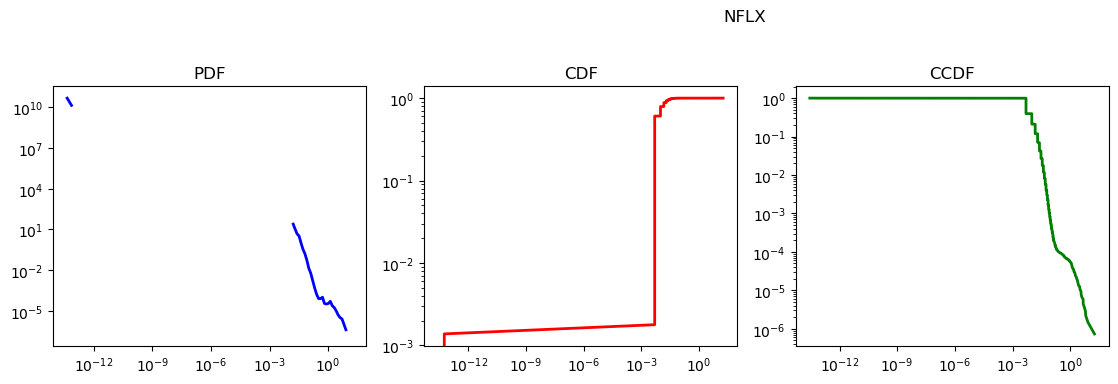

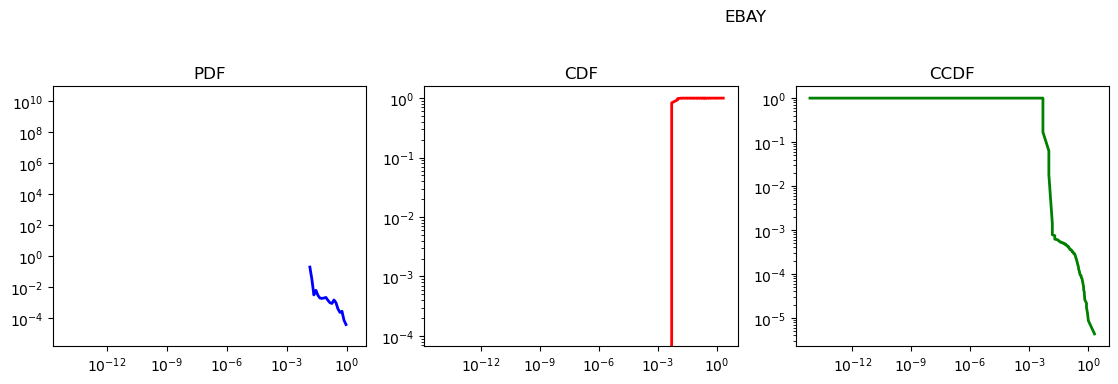

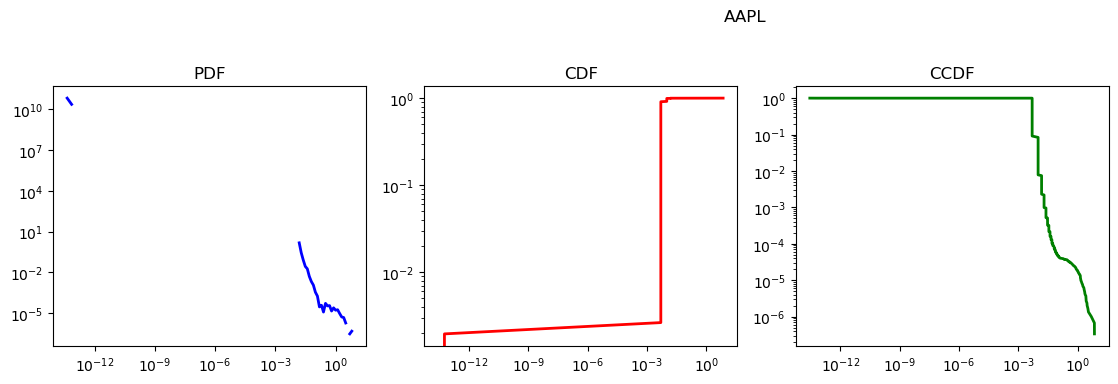

In [8]:
# Plot for each stock
for stock_name, data in returns.items():
    plot_distributions(stock_name, data)

### 1.3. Fit returns power law distribution

In [9]:
# 1. Fit Powerlaw and retrieve fitted object/ results
returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'lo_data', 'distributions', 'lo_returns_distributions.pkl')

if not os.path.exists(returns_distributions_data):
    returns_fit_objects = fit_powerlaw(data_dict=returns, filename=returns_distributions_data)
else:
    returns_fit_objects = load_fit_objects(returns_distributions_data)

returns_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x157caf410>,
 'MSFT': <powerlaw.Fit at 0x157b5c290>,
 'AMZN': <powerlaw.Fit at 0x1578d4f10>,
 'NFLX': <powerlaw.Fit at 0x39bcd4c90>,
 'EBAY': <powerlaw.Fit at 0x157c58ed0>,
 'AAPL': <powerlaw.Fit at 0x157951ed0>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

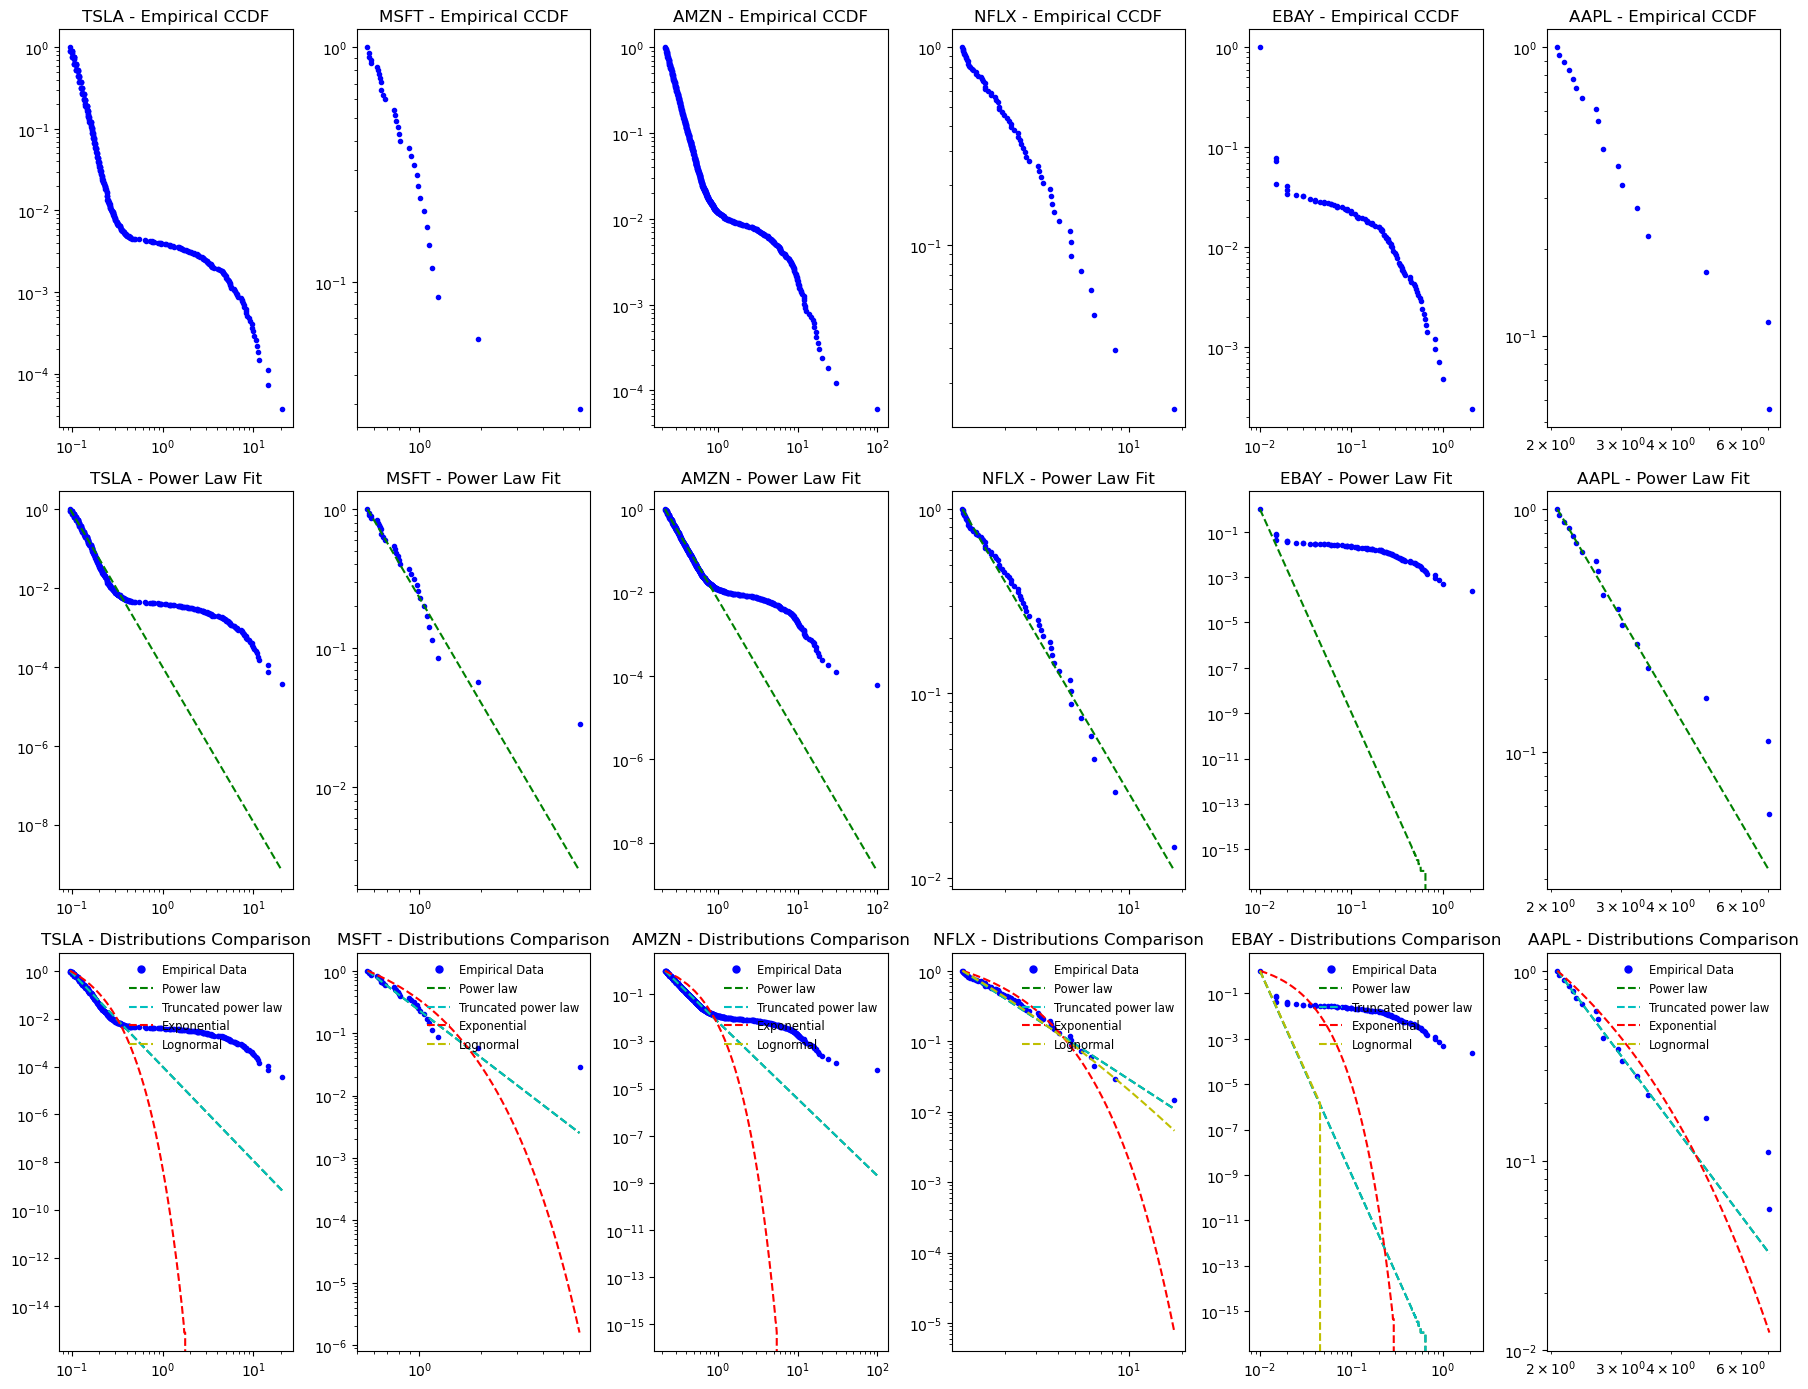

In [10]:
# Plot fitted objects
plot_fit_objects(returns_fit_objects)

#### 1.3.1. Retrieve returns power law fitting results

In [11]:
# Get fitting parameters for specific distribution across all stocks
returns_power_results = get_fitting_params(returns_fit_objects, 'power_law')
print(returns_power_results)

  Stock Distribution     alpha   xmin  KS Distance
0  TSLA    power_law  4.920034  0.095     0.093254
1  MSFT    power_law  3.518608  0.560     0.063724
2  AMZN    power_law  4.260557  0.215     0.035475
3  NFLX    power_law  2.638596  1.150     0.060899
4  EBAY    power_law  9.964914  0.010     0.051934
5  AAPL    power_law  3.803469  2.080     0.078074


In [12]:
# Average Alpha exponents across stocks
min_alpha = returns_power_results['alpha'].min()
max_alpha = returns_power_results['alpha'].max()
avg_alpha = returns_power_results['alpha'].mean()
std_dev_alpha = returns_power_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.638595963246697
Max Alpha: 9.964914156967682
Average Alpha: 4.8510296663706205
std_dev_alpha: 2.618122498217413


In [13]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
returns_power_results = get_fitting_params(returns_fit_objects, 'truncated_power_law')
print(returns_power_results)

  Stock         Distribution     alpha        Lambda   xmin  KS Distance
0  TSLA  truncated_power_law  4.919933  4.059798e-08  0.095     0.093254
1  MSFT  truncated_power_law  3.518594  1.087695e-08  0.560     0.063722
2  AMZN  truncated_power_law  4.260146  1.040803e-08  0.215     0.035512
3  NFLX  truncated_power_law  2.306942  7.342139e-02  1.150     0.069410
4  EBAY  truncated_power_law  9.964986  8.776080e-09  0.010     0.051935
5  AAPL  truncated_power_law  3.708106  1.965444e-02  2.080     0.079084


In [14]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
returns_power_results = get_fitting_params(returns_fit_objects, 'exponential')
print(returns_power_results)

  Stock Distribution      Lambda   xmin  KS Distance
0  TSLA  exponential   21.009707  0.095     0.216103
1  MSFT  exponential    2.440716  0.560     0.146107
2  AMZN  exponential    6.767019  0.215     0.255024
3  NFLX  exponential    0.696679  1.150     0.141782
4  EBAY  exponential  127.120881  0.010     0.486635
5  AAPL  exponential    0.879756  2.080     0.132593


#### 1.3.2. Compare Alternative Distributions

In [15]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
returns_powerlaw_exponential = distribution_compare(returns_fit_objects, 'exponential')
display(returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,21.009707,0.095,4.920034,0.093254,0.216103,10.477785,1.092725e-25
1,MSFT,exponential,2.440716,0.560,3.518608,0.063724,0.146107,1.276941,2.016232e-01
2,AMZN,exponential,6.767019,0.215,4.260557,0.035475,0.255024,9.926735,3.185154e-23
3,NFLX,exponential,0.696679,1.150,2.638596,0.060899,0.141782,1.127227,2.596465e-01
4,EBAY,exponential,127.120881,0.010,9.964914,0.051934,0.486635,25.756587,2.719813e-146
5,AAPL,exponential,0.879756,2.080,3.803469,0.078074,0.132593,1.266926,2.051817e-01


## 2. Percentage returns

In [16]:
# Compute percentage returns
tsla_percentage_returns = compute_returns(tsla_raw_df)['pct_returns']
msft_percentage_returns = compute_returns(msft_raw_df)['pct_returns']
amzn_percentage_returns = compute_returns(amzn_raw_df)['pct_returns']
nflx_percentage_returns = compute_returns(nflx_raw_df)['pct_returns']
ebay_percentage_returns = compute_returns(ebay_raw_df)['pct_returns']
appl_percentage_returns = compute_returns(appl_raw_df)['pct_returns']

percentage_returns = {
  'TSLA': tsla_percentage_returns,
  'MSFT': msft_percentage_returns,
  'AMZN': amzn_percentage_returns,
  'NFLX': nflx_percentage_returns,
  'EBAY': ebay_percentage_returns,
  'AAPL': appl_percentage_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in percentage_returns.items()}

### 2.1. Stationarity Test

In [17]:
# ADF test
for stock, data in percentage_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -232.14
p-value: 0.00,
N: 499991, 
critical values: {'1%': -3.430363078902566, '5%': -2.8615457807209896, '10%': -2.5667730768666197}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -109.32
p-value: 0.00,
N: 499958, 
critical values: {'1%': -3.43036307976585, '5%': -2.8615457811025506, '10%': -2.5667730770697106}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -351.94
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -189.83
p-value: 0.00,
N: 499987, 
critical values: {'1%': -3.4303630790072, '5%': -2.861545780767237, '10%': -2.5667730768912356}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EB

### 2.2. Percentage return density functions

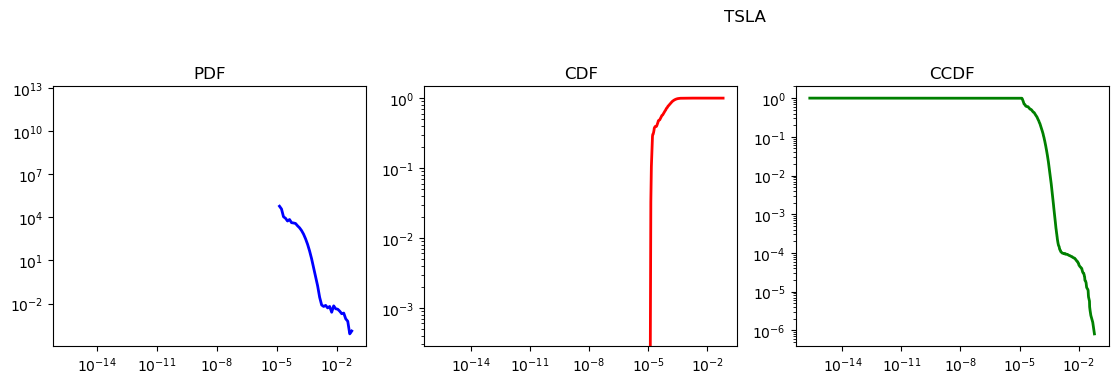

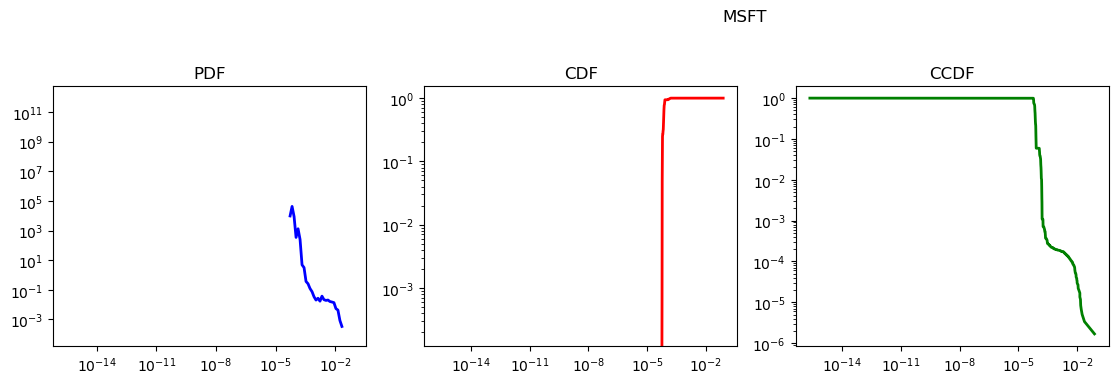

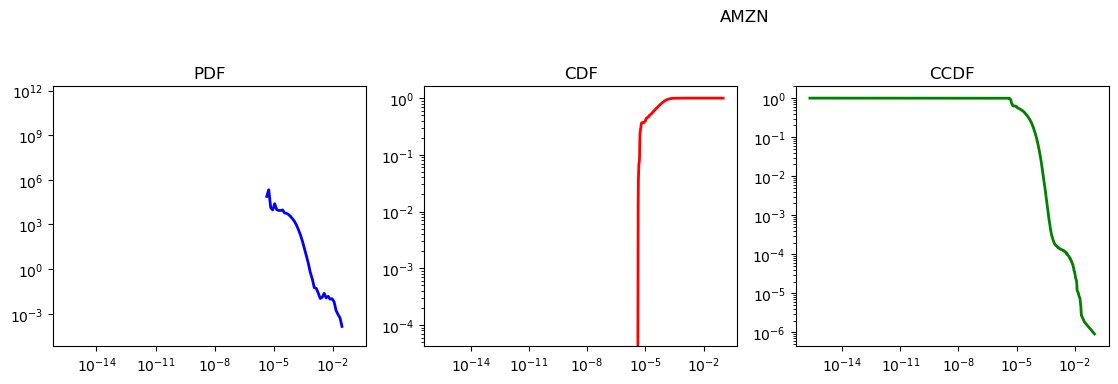

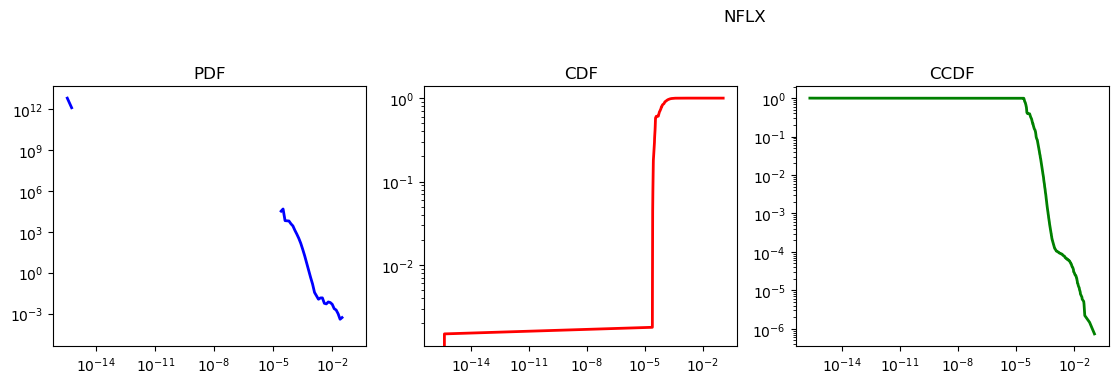

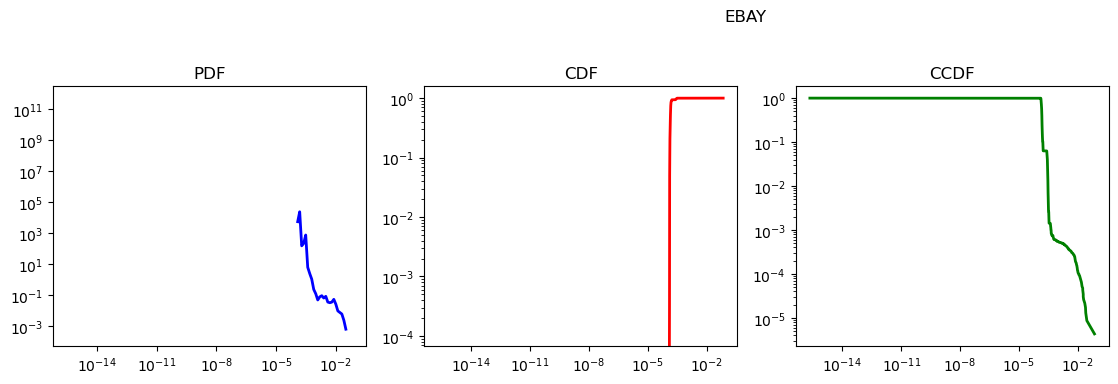

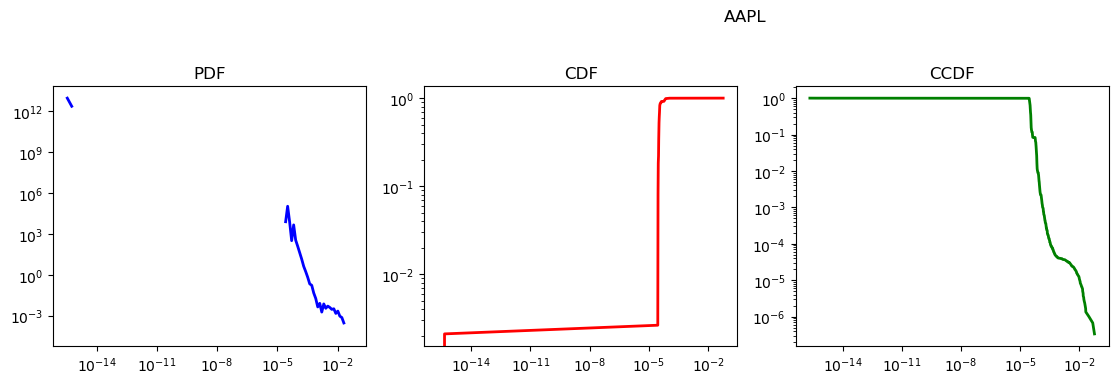

In [18]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in percentage_returns.items():
    plot_distributions(stock_name, data)

### 2.3. Fit power law distribution to percentage returns

In [19]:
# 1. Fit Powerlaw and retrieve fitted object/ results
percentage_returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'lo_data', 'distributions', 'lo_percentage_returns_distributions.pkl')

if not os.path.exists(percentage_returns_distributions_data):
    percentage_returns_fit_objects = fit_powerlaw(data_dict=percentage_returns, filename=percentage_returns_distributions_data)
else:
    percentage_returns_fit_objects = load_fit_objects(percentage_returns_distributions_data)

percentage_returns_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x78d8e3690>,
 'MSFT': <powerlaw.Fit at 0x157c2f050>,
 'AMZN': <powerlaw.Fit at 0x637d17410>,
 'NFLX': <powerlaw.Fit at 0x637d17450>,
 'EBAY': <powerlaw.Fit at 0x76ac44290>,
 'AAPL': <powerlaw.Fit at 0x637d17050>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

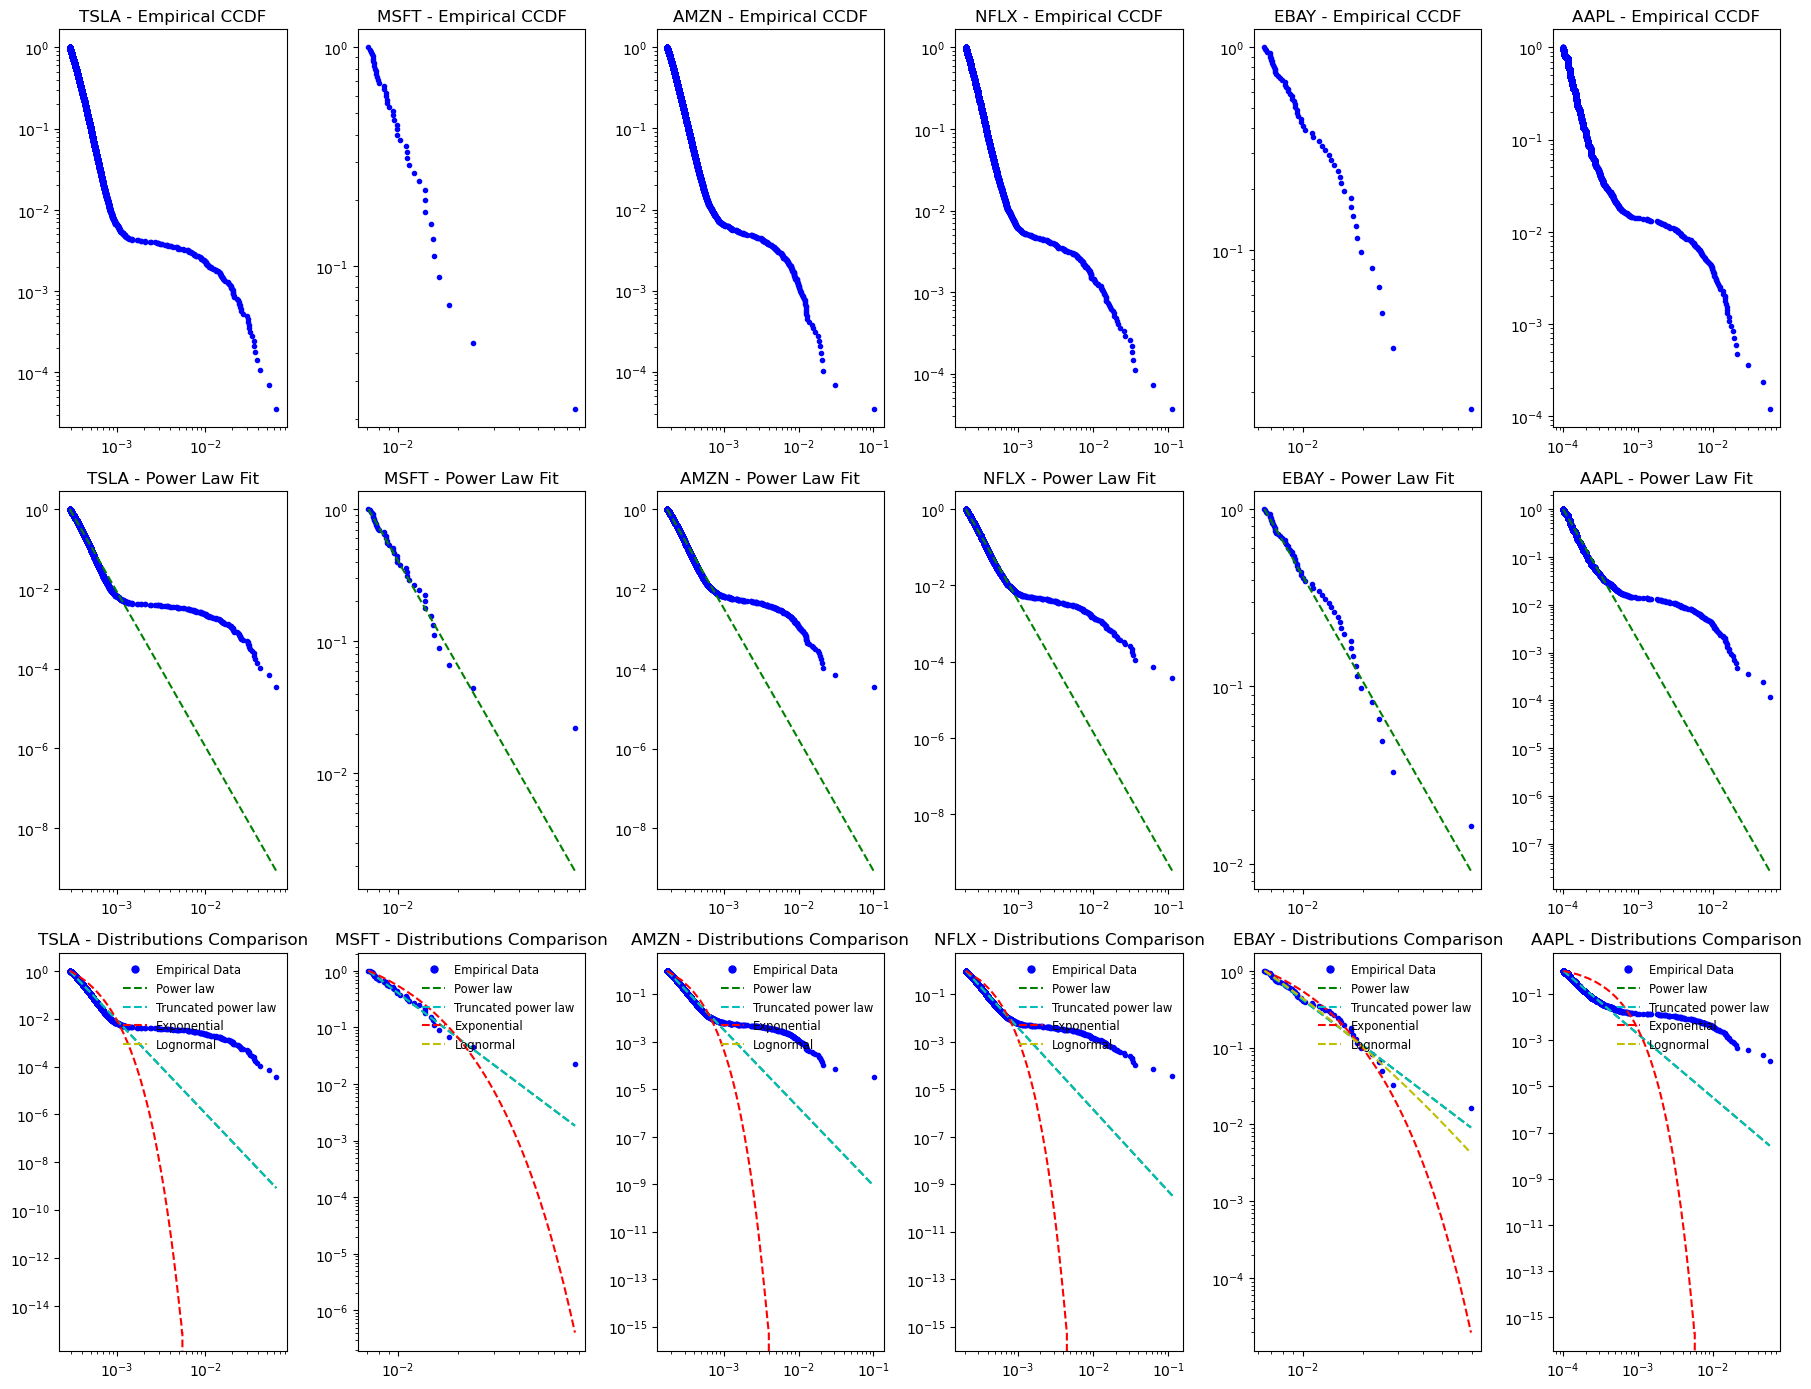

In [20]:
# Plot fitted objects
plot_fit_objects(percentage_returns_fit_objects)

#### 2.3.1. Retrieve Power law fitting results

In [21]:
# Get fitting parameters for specific distribution across all stocks
percentage_returns_results = get_fitting_params(percentage_returns_fit_objects, 'power_law')
print(percentage_returns_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  4.873718  0.000291     0.021402
1  MSFT    power_law  3.657214  0.007117     0.046965
2  AMZN    power_law  4.283859  0.000175     0.020199
3  NFLX    power_law  4.457178  0.000204     0.019519
4  EBAY    power_law  2.978373  0.006458     0.063442
5  AAPL    power_law  3.740215  0.000101     0.078213


In [22]:
# Average Alpha exponents across stocks
min_alpha = percentage_returns_results['alpha'].min()
max_alpha = percentage_returns_results['alpha'].max()
avg_alpha = percentage_returns_results['alpha'].mean()
std_dev_alpha = percentage_returns_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.9783733529141836
Max Alpha: 4.873717811578862
Average Alpha: 3.9984260749174454
std_dev_alpha: 0.6755245517580906


In [23]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
percentage_returns_results = get_fitting_params(percentage_returns_fit_objects, 'truncated_power_law')
print(percentage_returns_results)

  Stock         Distribution     alpha     Lambda      xmin  KS Distance
0  TSLA  truncated_power_law  4.873618   0.000013  0.000291     0.021407
1  MSFT  truncated_power_law  3.658010   0.000031  0.007117     0.047053
2  AMZN  truncated_power_law  4.284026   0.000009  0.000175     0.020184
3  NFLX  truncated_power_law  4.457189   0.000014  0.000204     0.019520
4  EBAY  truncated_power_law  2.567574  20.850683  0.006458     0.054027
5  AAPL  truncated_power_law  3.740202   0.000004  0.000101     0.078212


In [24]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
percentage_returns_results = get_fitting_params(percentage_returns_fit_objects, 'exponential')
print(percentage_returns_results)

  Stock Distribution       Lambda      xmin  KS Distance
0  TSLA  exponential  6735.951573  0.000291     0.193273
1  MSFT  exponential   212.798058  0.007117     0.152047
2  AMZN  exponential  9296.245211  0.000175     0.195023
3  NFLX  exponential  8240.677057  0.000204     0.209549
4  EBAY  exponential   172.234150  0.006458     0.135696
5  AAPL  exponential  6435.401553  0.000101     0.468913


#### 2.3.2. Compare Alternative Distributions

In [25]:
# Compare against alternative heavy-tailed distributions
percentage_returns_powerlaw_exponential = distribution_compare(percentage_returns_fit_objects, 'exponential')
display(percentage_returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,6735.951573,0.000291,4.873718,0.021402,0.193273,10.506373,8.073960e-26
1,MSFT,exponential,212.798058,0.007117,3.657214,0.046965,0.152047,1.214572,2.245294e-01
2,AMZN,exponential,9296.245211,0.000175,4.283859,0.020199,0.195023,9.529477,1.580778e-21
3,NFLX,exponential,8240.677057,0.000204,4.457178,0.019519,0.209549,8.606576,7.527541e-18
4,EBAY,exponential,172.234150,0.006458,2.978373,0.063442,0.135696,0.841201,4.002354e-01
5,AAPL,exponential,6435.401553,0.000101,3.740215,0.078213,0.468913,13.720558,7.647488e-43


## 3. Log Returns

In [26]:
# Compute log returns
tsla_log_returns = compute_returns(tsla_raw_df, )['log_returns']
msft_log_returns = compute_returns(msft_raw_df, )['log_returns']
amzn_log_returns = compute_returns(amzn_raw_df,)['log_returns']
nflx_log_returns = compute_returns(nflx_raw_df, )['log_returns']
ebay_log_returns = compute_returns(ebay_raw_df,)['log_returns']
appl_log_returns = compute_returns(appl_raw_df,)['log_returns']

log_returns = {
  'TSLA': tsla_log_returns,
  'MSFT': msft_log_returns,
  'AMZN': amzn_log_returns,
  'NFLX': nflx_log_returns,
  'EBAY': ebay_log_returns,
  'AAPL': appl_log_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in log_returns.items()}

### 3.1. Stationarity Test

In [27]:
# ADF test
for stock, data in log_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -232.14
p-value: 0.00,
N: 499990, 
critical values: {'1%': -3.4303630789287243, '5%': -2.8615457807325515, '10%': -2.566773076872774}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -109.32
p-value: 0.00,
N: 499957, 
critical values: {'1%': -3.4303630797920124, '5%': -2.861545781114114, '10%': -2.5667730770758657}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -351.95
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -189.65
p-value: 0.00,
N: 499986, 
critical values: {'1%': -3.4303630790333592, '5%': -2.861545780778799, '10%': -2.5667730768973893}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary

### 3.2. Log return density functions

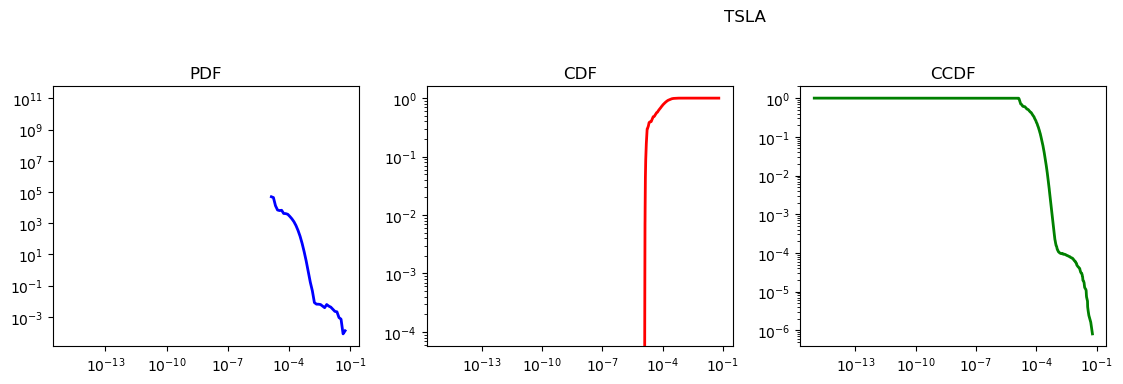

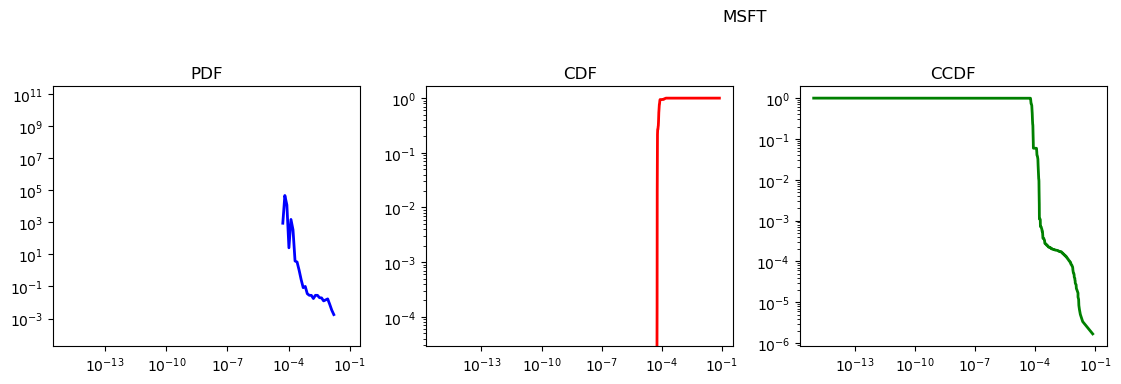

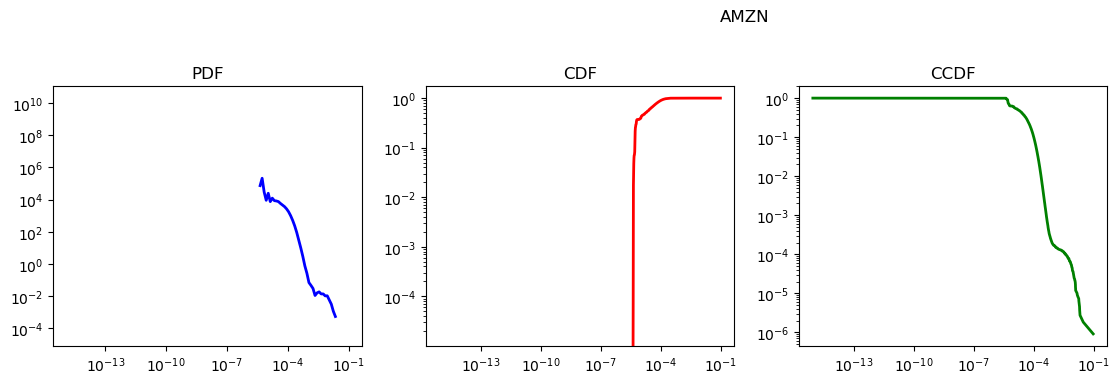

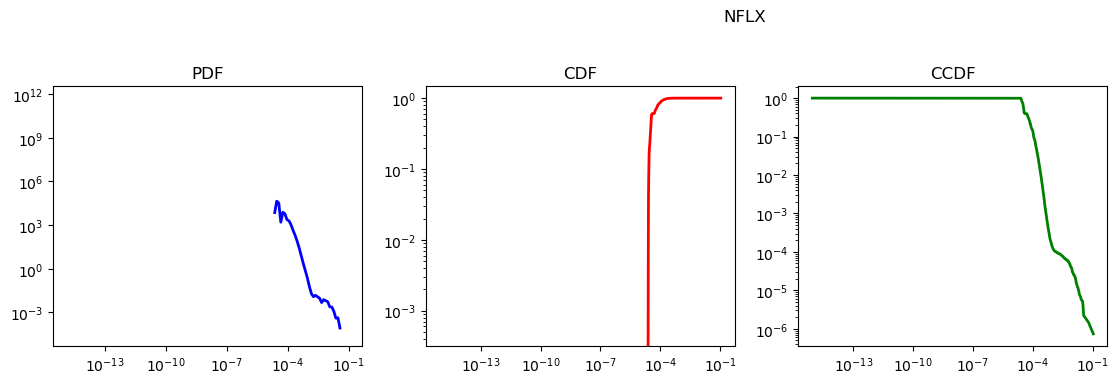

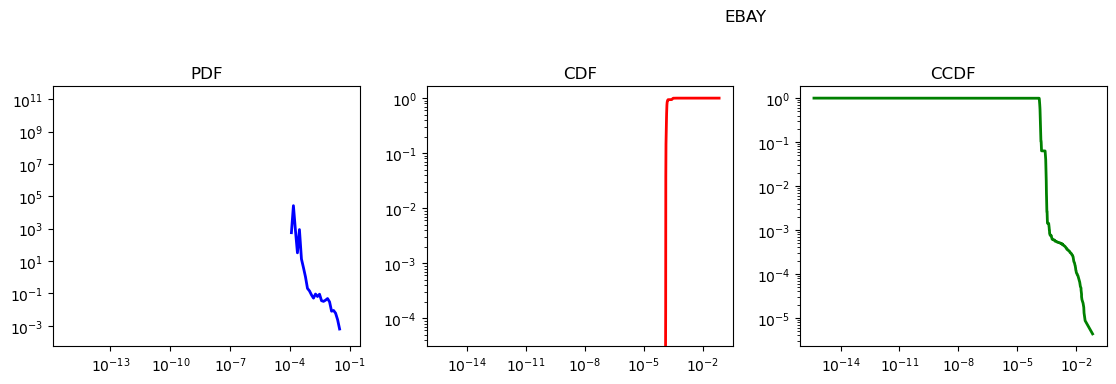

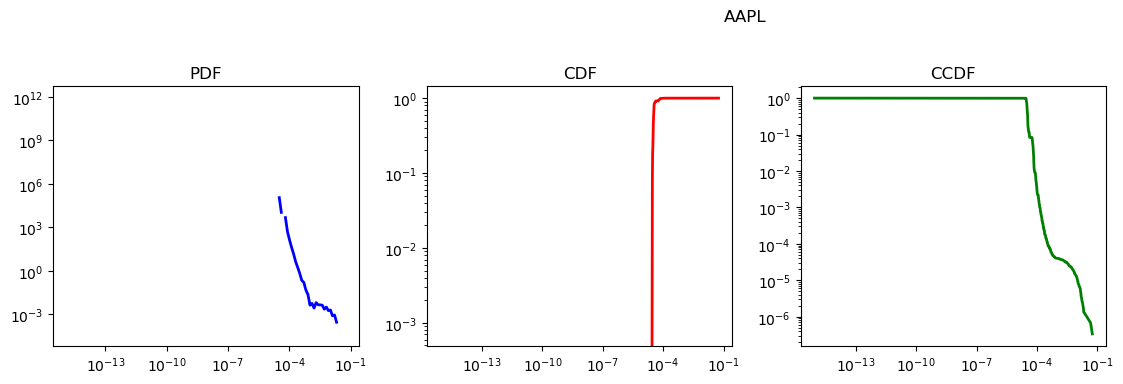

In [28]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in log_returns.items():
    plot_distributions(stock_name, data)

### 3.3. Fit power law distribution to log returns

In [29]:
# 1. Fit Powerlaw and retrieve fitted object/ results
log_returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'lo_data', 'distributions', 'lo_log_returns_distributions.pkl')

if not os.path.exists(log_returns_distributions_data):
    log_returns_fit_objects = fit_powerlaw(data_dict=log_returns, filename=log_returns_distributions_data)
else:
    log_returns_fit_objects = load_fit_objects(log_returns_distributions_data)

log_returns_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x3139f8e90>,
 'MSFT': <powerlaw.Fit at 0x3df8df410>,
 'AMZN': <powerlaw.Fit at 0x3c217f410>,
 'NFLX': <powerlaw.Fit at 0x3c215a510>,
 'EBAY': <powerlaw.Fit at 0x2b779cc90>,
 'AAPL': <powerlaw.Fit at 0x3abcfbb90>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

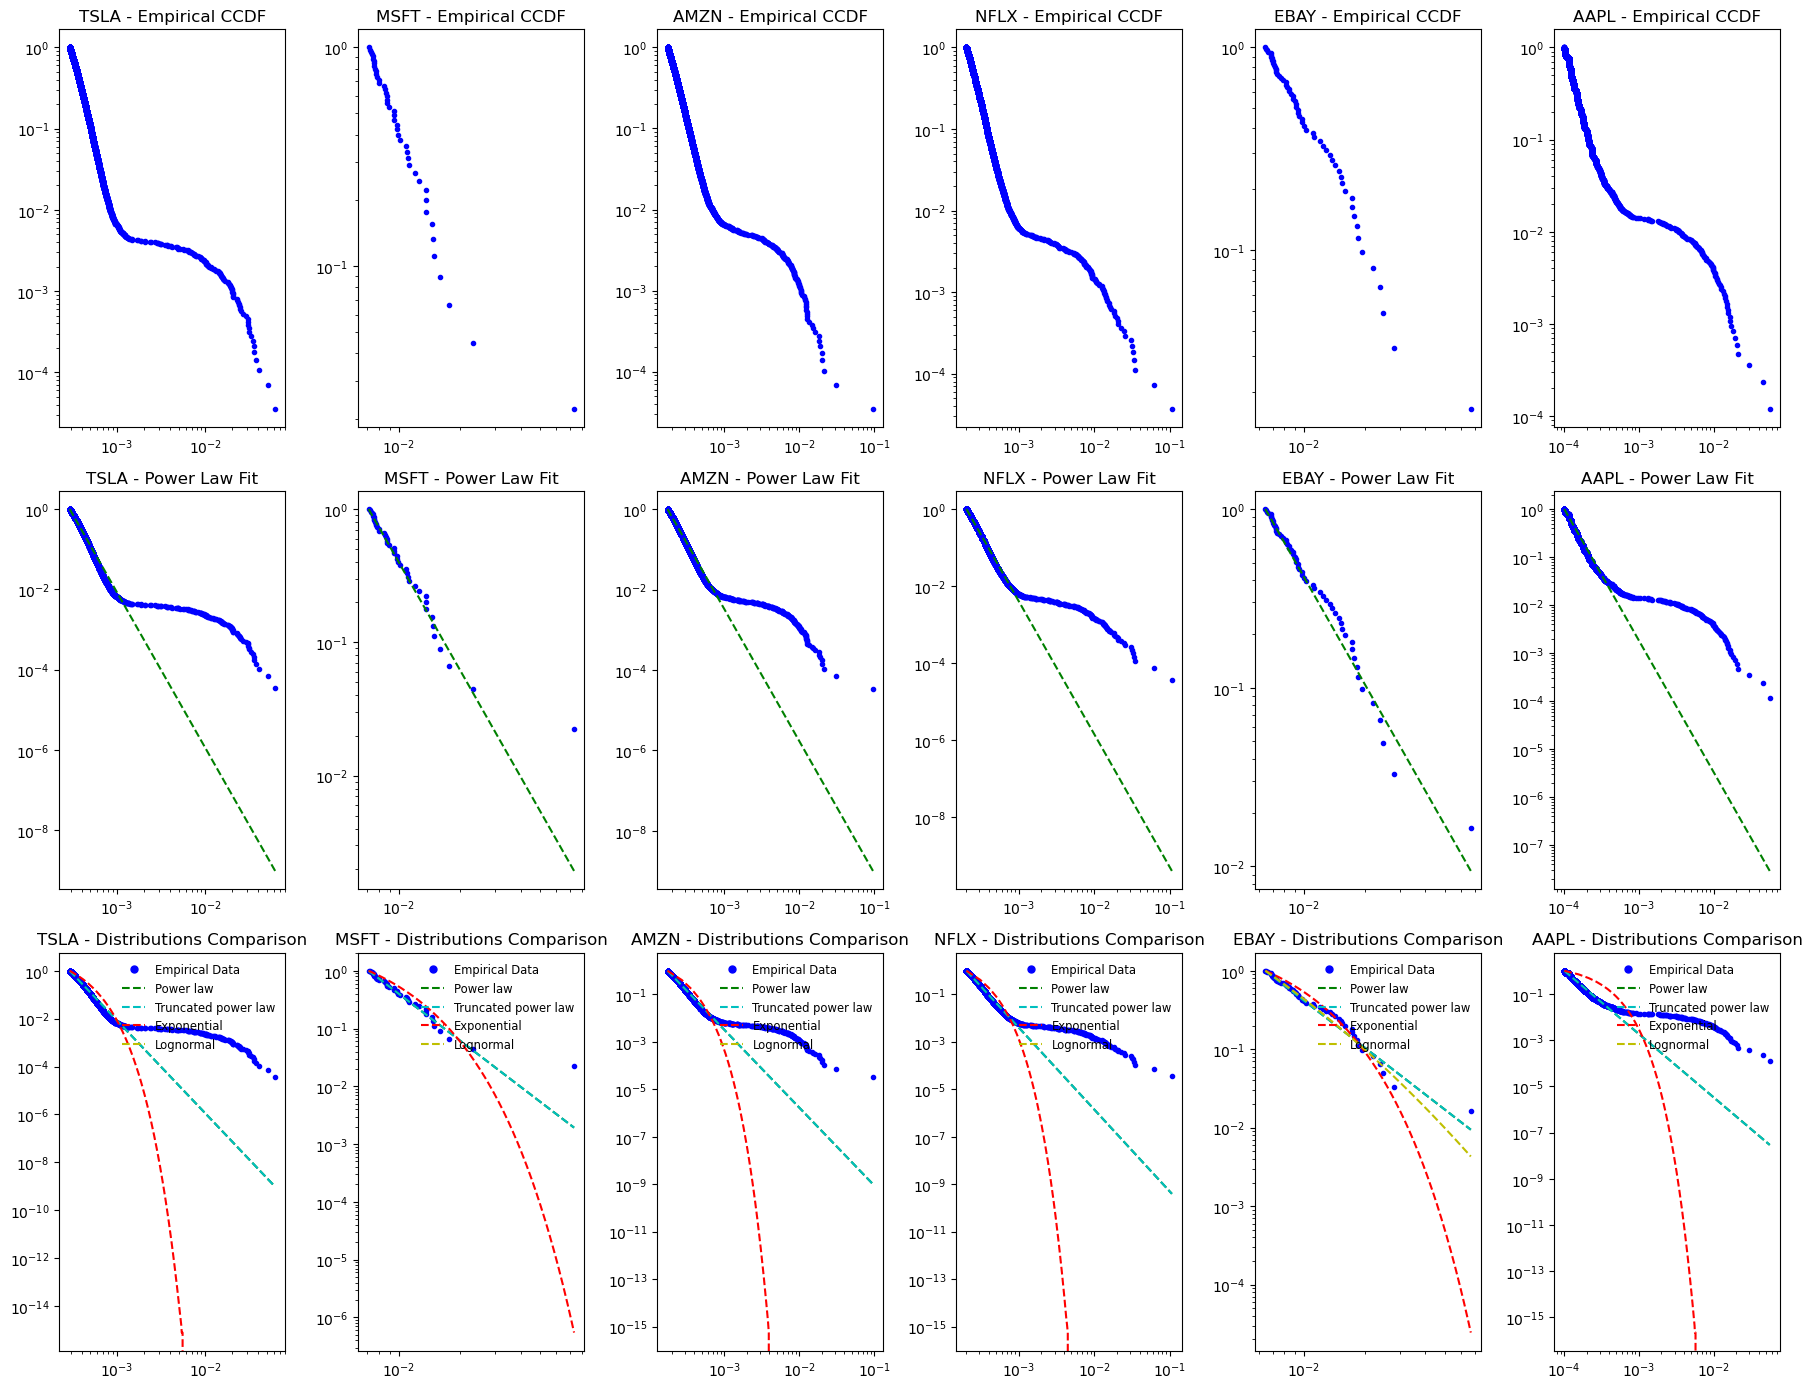

In [30]:
# Plot fitted objects
plot_fit_objects(log_returns_fit_objects)

#### 3.3.1. Retrieve Power law fitting results

In [31]:
# Get fitting parameters for specific distribution across all stocks
log_returns_results = get_fitting_params(log_returns_fit_objects, 'power_law')
print(log_returns_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  4.874828  0.000291     0.021384
1  MSFT    power_law  3.673628  0.007092     0.047640
2  AMZN    power_law  4.284438  0.000175     0.020183
3  NFLX    power_law  4.457900  0.000204     0.019545
4  EBAY    power_law  2.989649  0.006437     0.063757
5  AAPL    power_law  3.740721  0.000101     0.078275


In [32]:
# Average Alpha exponents across stocks
min_alpha = log_returns_results['alpha'].min()
max_alpha = log_returns_results['alpha'].max()
avg_alpha = log_returns_results['alpha'].mean()
std_dev_alpha = log_returns_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.989648631315413
Max Alpha: 4.8748275708911315
Average Alpha: 4.003527158542398
std_dev_alpha: 0.6708769932936263


In [33]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
log_returns_results = get_fitting_params(log_returns_fit_objects, 'truncated_power_law')
print(log_returns_results)

  Stock         Distribution     alpha     Lambda      xmin  KS Distance
0  TSLA  truncated_power_law  4.874728   0.000013  0.000291     0.021389
1  MSFT  truncated_power_law  3.711330   0.000063  0.007092     0.051813
2  AMZN  truncated_power_law  4.284482   0.000001  0.000175     0.020179
3  NFLX  truncated_power_law  4.457892   0.000004  0.000204     0.019545
4  EBAY  truncated_power_law  2.550432  22.676408  0.006437     0.054042
5  AAPL  truncated_power_law  3.740713   0.000007  0.000101     0.078274


In [34]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
log_returns_results = get_fitting_params(log_returns_fit_objects, 'exponential')
print(log_returns_results)

  Stock Distribution       Lambda      xmin  KS Distance
0  TSLA  exponential  6768.040664  0.000291     0.191713
1  MSFT  exponential   217.133645  0.007092     0.148203
2  AMZN  exponential  9328.453392  0.000175     0.193903
3  NFLX  exponential  8282.651949  0.000204     0.207992
4  EBAY  exponential   175.016899  0.006437     0.133190
5  AAPL  exponential  6471.384350  0.000101     0.467530


#### 3.3.2. Compare Alternative Distributions

In [35]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
log_returns_powerlaw_exponential = distribution_compare(log_returns_fit_objects, 'exponential')
display(log_returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,6768.040664,0.000291,4.874828,0.021384,0.191713,10.532840,6.096651e-26
1,MSFT,exponential,217.133645,0.007092,3.673628,0.047640,0.148203,1.199239,2.304349e-01
2,AMZN,exponential,9328.453392,0.000175,4.284438,0.020183,0.193903,9.716861,2.555388e-22
3,NFLX,exponential,8282.651949,0.000204,4.457900,0.019545,0.207992,8.750274,2.128362e-18
4,EBAY,exponential,175.016899,0.006437,2.989649,0.063757,0.133190,0.815278,4.149131e-01
5,AAPL,exponential,6471.384350,0.000101,3.740721,0.078275,0.467530,13.807577,2.294204e-43


## 4. Return magnitudes (volatility)

In [36]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

return_magnitudes = {
  'TSLA': tsla_volatility,
  'MSFT': msft_volatility,
  'AMZN': amzn_volatility,
  'NFLX': nflx_volatility,
  'EBAY': ebay_volatility,
  'AAPL': appl_volatility
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#return_magnitudes = {stock: data.head(1000000) for stock, data in return_magnitudes.items()}

### 4.1. Stationarity Test

In [37]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -67.46
p-value: 0.00,
N: 499911, 
critical values: {'1%': -3.4303630809955736, '5%': -2.8615457816460723, '10%': -2.566773077359008}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -60.43
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -81.01
p-value: 0.00,
N: 499936, 
critical values: {'1%': -3.430363080341437, '5%': -2.8615457813569525, '10%': -2.5667730772051196}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -81.79
p-value: 0.00,
N: 499936, 
critical values: {'1%': -3.430363080341437, '5%': -2.8615457813569525, '10%': -2.5667730772051196}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.




### 4.2. Volatility density functions

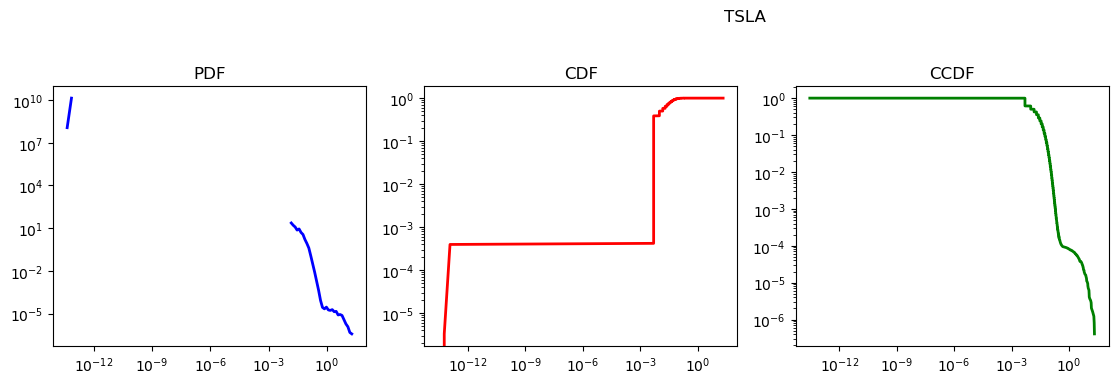

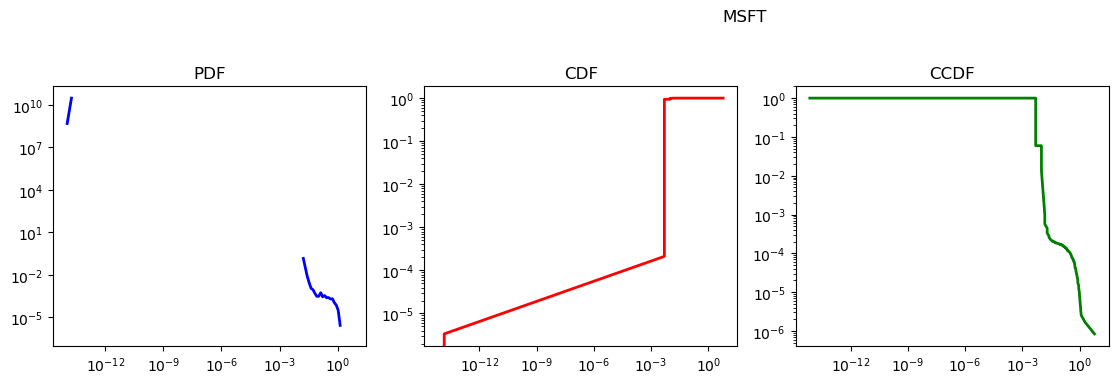

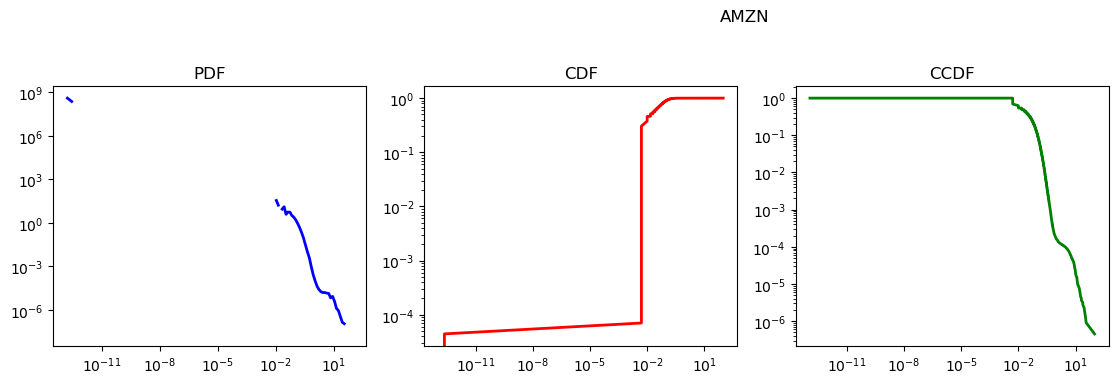

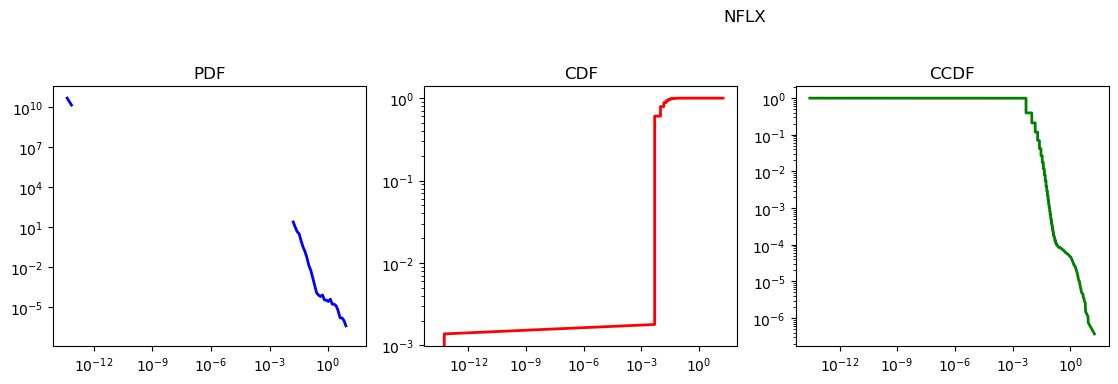

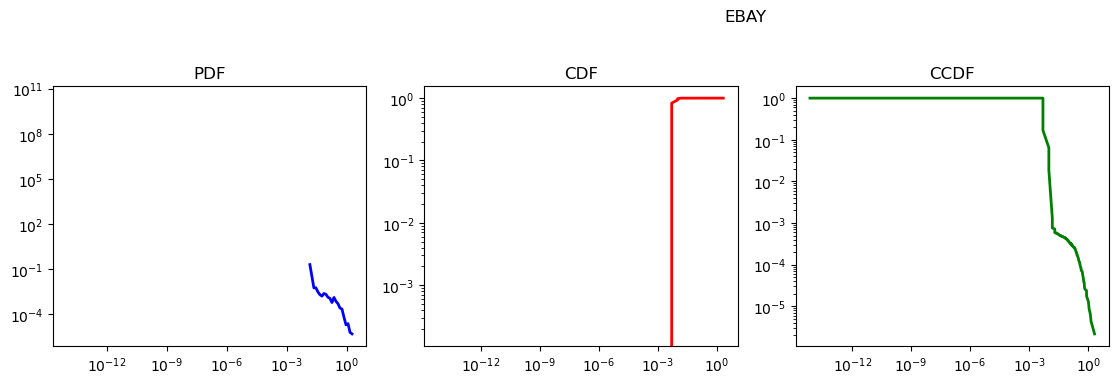

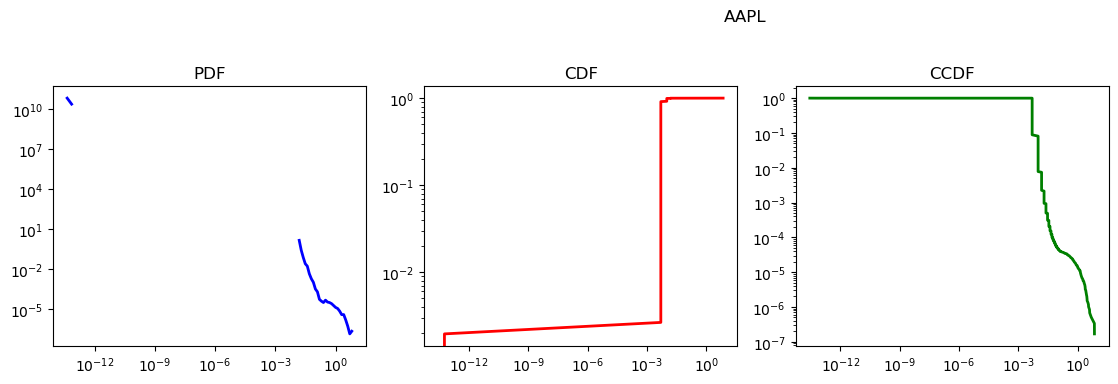

In [38]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in return_magnitudes.items():
    plot_distributions(stock_name, data)

### 4.3. Fit power law distribution to log returns

In [39]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volatility_data = os.path.join(root_dir, 'data', 'generated', 'lo_data', 'distributions', 'lo_volatility_distributions.pkl')

if not os.path.exists(volatility_data):
    volatility_fit_objects = fit_powerlaw(data_dict=return_magnitudes, filename=volatility_data)
else:
    volatility_fit_objects = load_fit_objects(volatility_data)

volatility_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x3df7e8850>,
 'MSFT': <powerlaw.Fit at 0x157bd8b10>,
 'AMZN': <powerlaw.Fit at 0x3abee08d0>,
 'NFLX': <powerlaw.Fit at 0x3c20b95d0>,
 'EBAY': <powerlaw.Fit at 0x157b58510>,
 'AAPL': <powerlaw.Fit at 0x3abf0c790>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


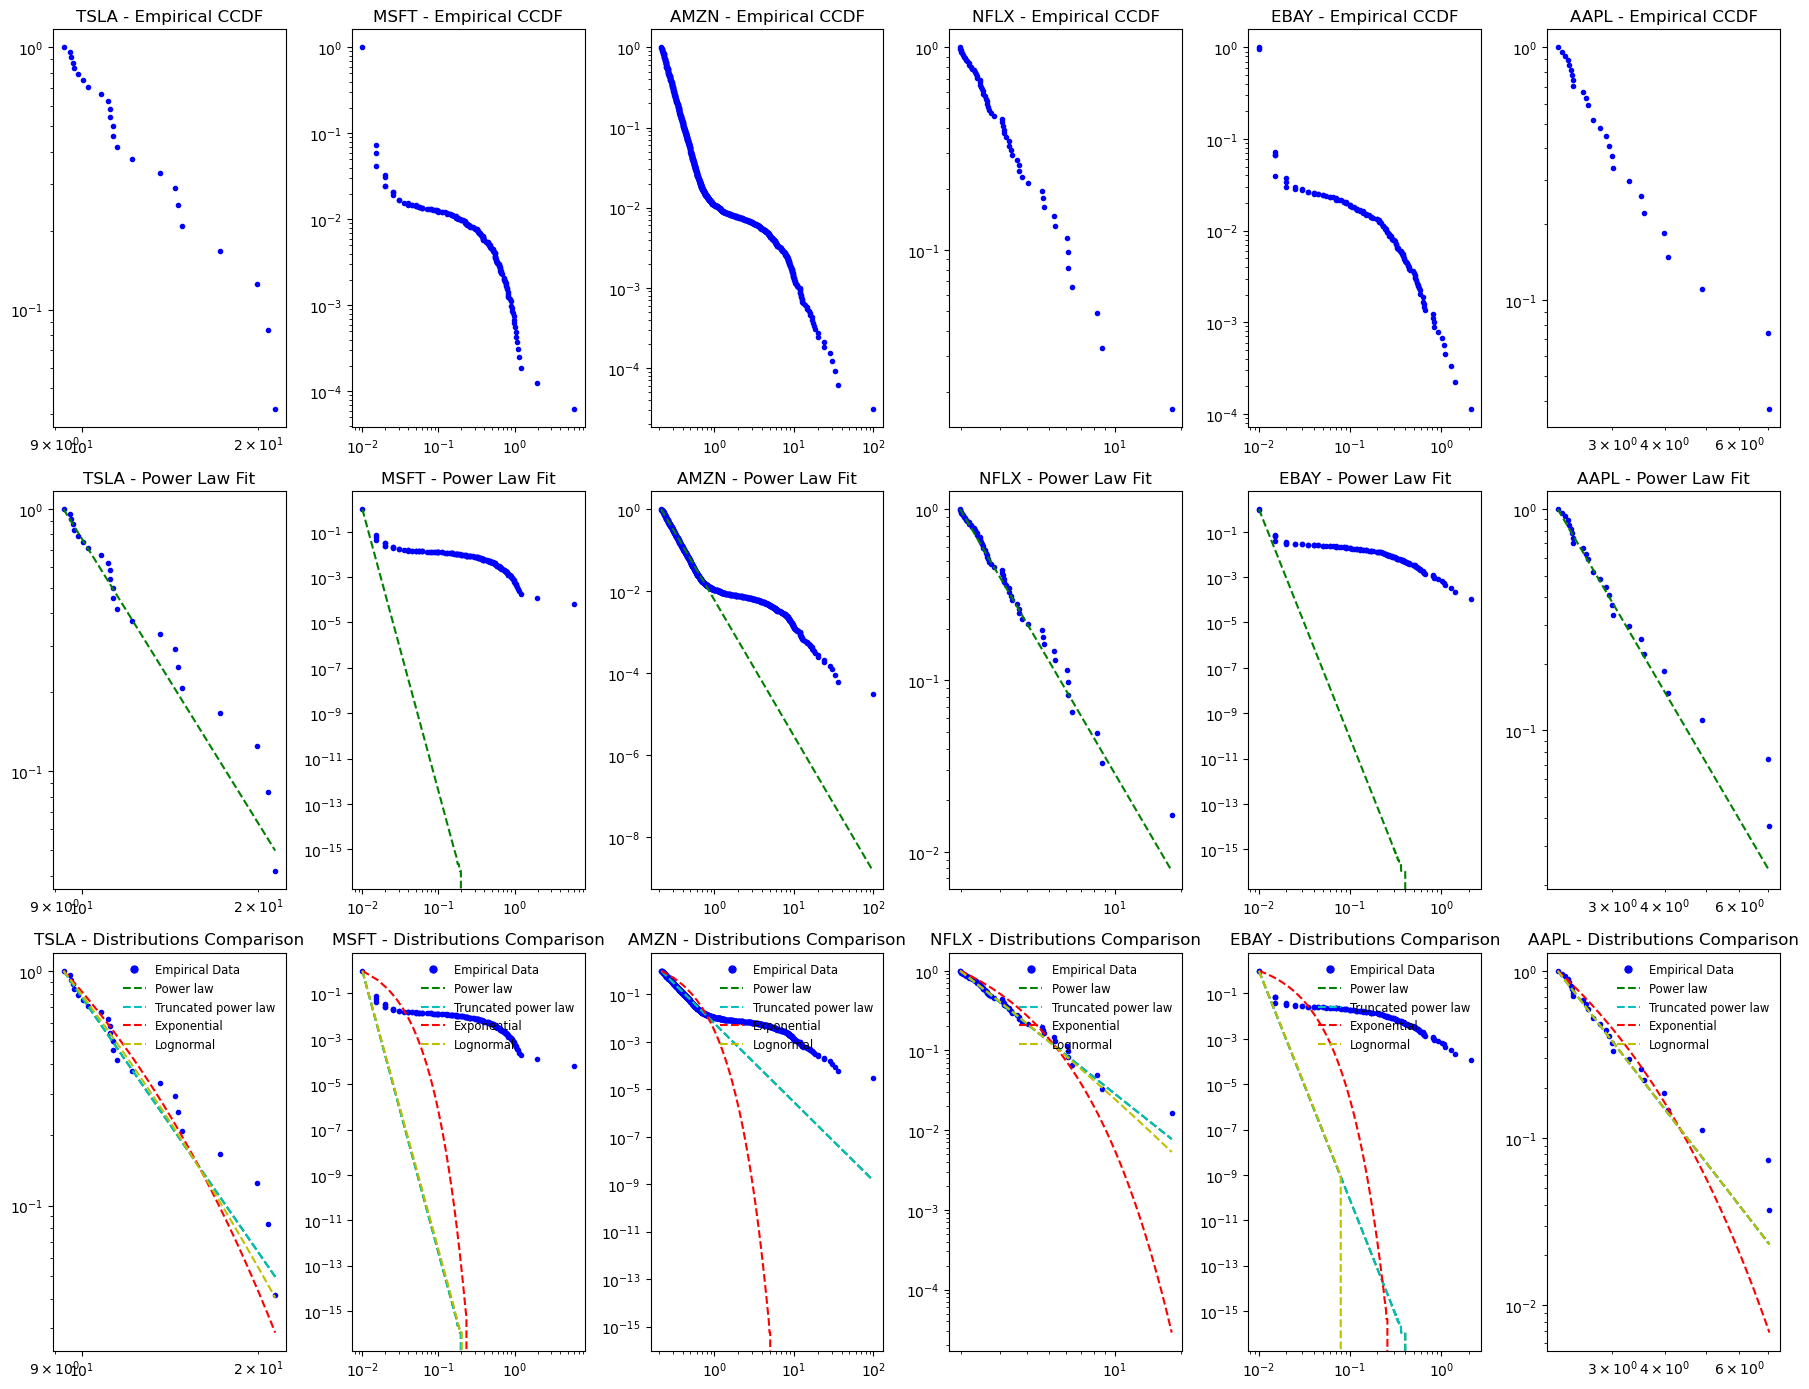

In [40]:
# Plot fitted objects
plot_fit_objects(volatility_fit_objects)

#### 4.3.1. Retrieve Power law fitting results

In [41]:
# Get fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'power_law')
print(volatility_fit_results)

  Stock Distribution      alpha   xmin  KS Distance
0  TSLA    power_law   4.605586  9.310     0.090238
1  MSFT    power_law  13.447355  0.010     0.067553
2  AMZN    power_law   4.316638  0.215     0.034837
3  NFLX    power_law   3.193917  1.975     0.061328
4  EBAY    power_law  11.114526  0.010     0.055556
5  AAPL    power_law   4.262617  2.230     0.057668


In [42]:
# Average Alpha exponents across stocks
min_alpha = volatility_fit_results['alpha'].min()
max_alpha = volatility_fit_results['alpha'].max()
avg_alpha = volatility_fit_results['alpha'].mean()
std_dev_alpha = volatility_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.1939172176742314
Max Alpha: 13.447354935947063
Average Alpha: 6.823440022193395
std_dev_alpha: 4.317959023725202


In [43]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'truncated_power_law')
print(volatility_fit_results)

  Stock         Distribution      alpha        Lambda   xmin  KS Distance
0  TSLA  truncated_power_law   2.575797  1.262645e-01  9.310     0.082163
1  MSFT  truncated_power_law  13.447385  5.741389e-09  0.010     0.067553
2  AMZN  truncated_power_law   4.316649  1.318627e-08  0.215     0.034837
3  NFLX  truncated_power_law   2.952819  4.248813e-02  1.975     0.051669
4  EBAY  truncated_power_law  11.114551  5.541537e-09  0.010     0.055556
5  AAPL  truncated_power_law   4.070310  4.283603e-02  2.230     0.055249


In [44]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'exponential')
print(volatility_fit_results)

  Stock Distribution      Lambda   xmin  KS Distance
0  TSLA  exponential    0.293542  9.310     0.113772
1  MSFT  exponential  158.926995  0.010     0.409533
2  AMZN  exponential    7.346809  0.215     0.233052
3  NFLX  exponential    0.647567  1.975     0.141672
4  EBAY  exponential  145.343198  0.010     0.444294
5  AAPL  exponential    1.028764  2.230     0.110331


#### 3.3.2. Compare Alternative Distributions

In [45]:
# Compare against alternative heavy-tailed distributions
volatility_powerlaw_exponential = distribution_compare(volatility_fit_objects, 'exponential')
display(volatility_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,0.293542,9.310,4.605586,0.090238,0.113772,-0.008375,9.933180e-01
1,MSFT,exponential,158.926995,0.010,13.447355,0.067553,0.409533,29.636335,5.087598e-193
2,AMZN,exponential,7.346809,0.215,4.316638,0.034837,0.233052,13.538625,9.250381e-42
3,NFLX,exponential,0.647567,1.975,3.193917,0.061328,0.141672,1.116601,2.641648e-01
4,EBAY,exponential,145.343198,0.010,11.114526,0.055556,0.444294,35.276194,1.361245e-272
5,AAPL,exponential,1.028764,2.230,4.262617,0.057668,0.110331,1.050239,2.936083e-01
